In [429]:
import boto3 # connecting to AWS
from botocore.exceptions import NoCredentialsError
from botocore.exceptions import ClientError
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import OrderedDict
from pprint import pprint
from datetime import datetime
from pandas import DataFrame
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from reportlab.pdfgen import canvas
import operator
import credentials # credentials.py file in repository

In [430]:
# connecting to local directory and getting images from folder
dir_path = os.path.abspath('')
img_path = dir_path + '/images'
#get tuple of list of images found in local dir
images = next(os.walk(img_path))[2:]
# ensure all images are actually jpg's
for i in images[0]:
    if i.find('.jpeg')<0:
        images[0].remove(i)

In [431]:
images

(['IMG_2823.jpeg', 'IMG_2828.jpeg', 'IMG_2794-1.jpeg', 'IMG_2801-1.jpeg'],)

In [432]:
# Access Key and Secret Key for AWS
ACCESS_KEY = credentials.ACCESS_KEY
SECRET_KEY = credentials.SECRET_KEY
# mssql_cred = credentials.DBWiD

In [433]:
# Get key of object in bucket with a specified prefix
s3client = boto3.client('s3',  aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)
s3 = boto3.resource('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)

# Target S3 bucket name and resource
# bucket_name = 'kubrick-women-in-data'
bucket_name = 'wid'
s3_bucket = s3.Bucket(bucket_name)

In [434]:
# add images to folder in AWS
s3_target_location = 'mugshots/'

In [435]:
# check if images are already in the AWS bucket
for f in images[0]:
    if s3_target_location in [i.key for i in s3_bucket.objects.all()]:
        print(s3_target_location + " already in bucket")
    else:
        # Upload the image to s3
        s3client.upload_file(Filename=img_path+'/'+f, Bucket=bucket_name, Key=s3_target_location+f)

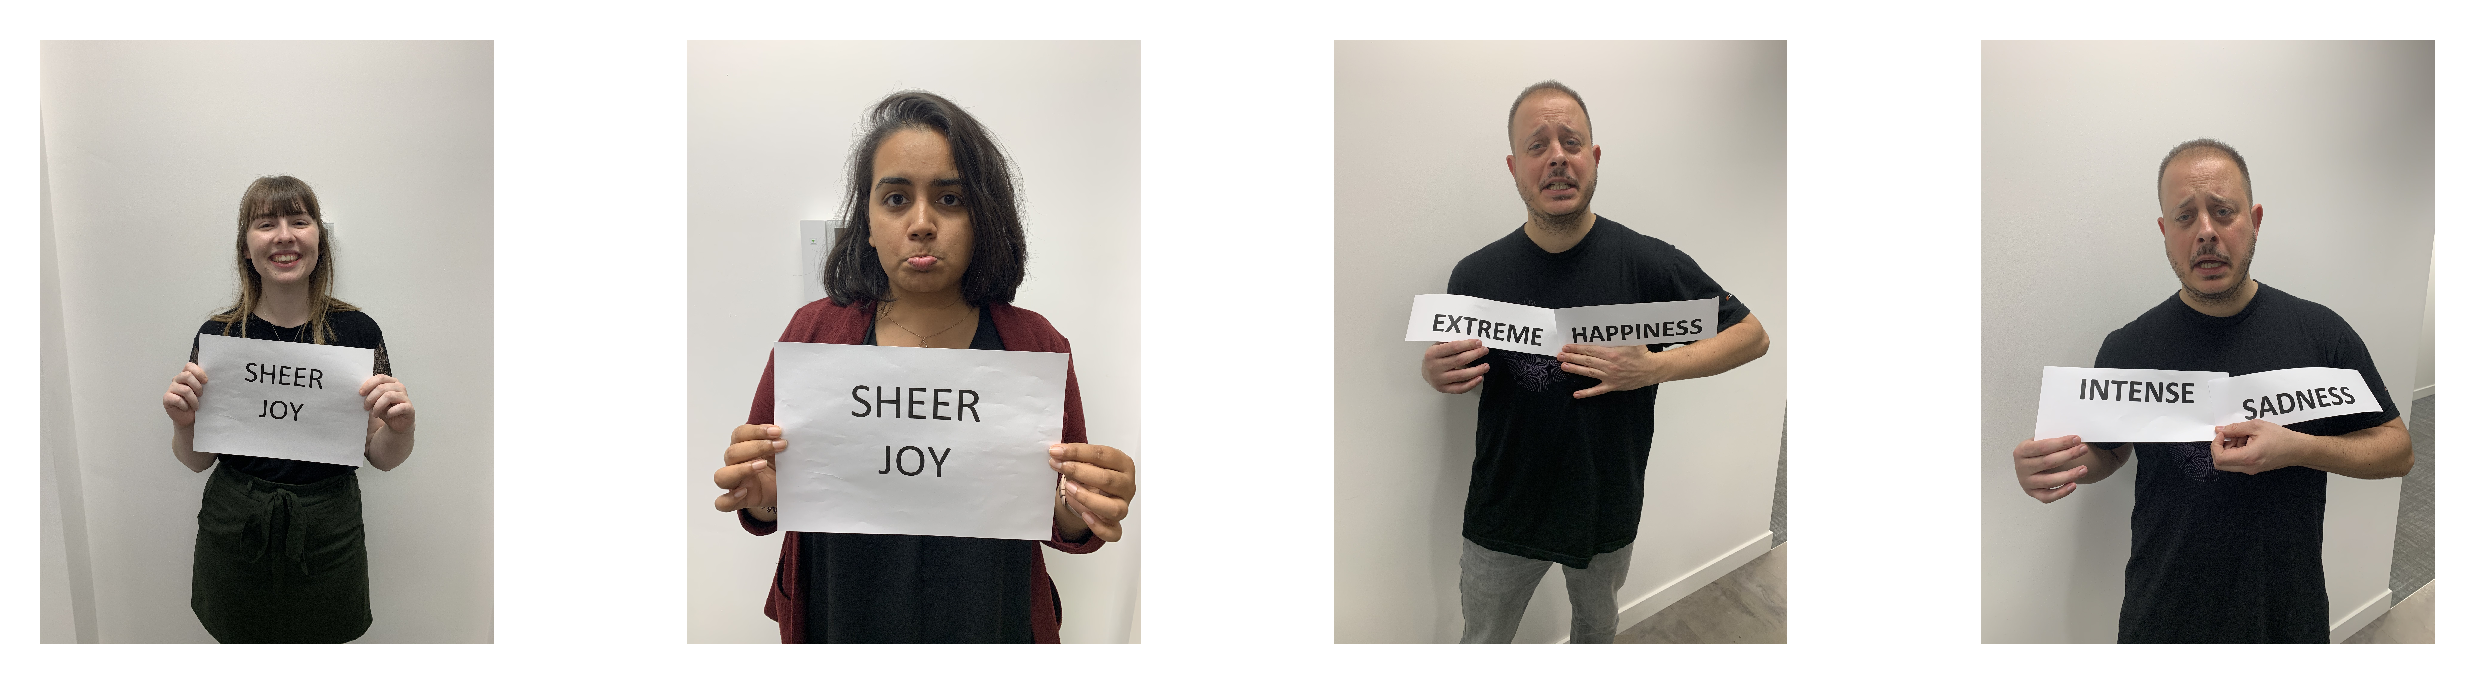

In [436]:
# example images showing a written statement of emotion and a facial expression of emotion
fig = plt.figure(figsize=(8, 2), dpi=400)

for i in range(0, len(images[0])):
    img = cv2.imread(img_path+'/'+images[0][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    a = fig.add_subplot(1, len(images[0]), i+1)
    plt.axis('off')
    imgplot = plt.imshow(img)

In [437]:
# use AWS rekognition to detect faces
def detect_faces(bucket, key, attributes=['ALL'], region='eu-west-2'):
    rekognition = boto3.client('rekognition', region_name='eu-west-2', 
                               aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)
    response = rekognition.detect_faces(
        Image={
            'S3Object': {
                'Bucket': bucket,
                'Name': key,
            }
        },
        Attributes=attributes,
    )
    return response['FaceDetails']

In [438]:
# use textract to read the words from the statement
def detect_text(bucket, key):
    # Set up textract client
    textract_client = boto3.client('textract', aws_access_key_id=ACCESS_KEY,
                          aws_secret_access_key=SECRET_KEY, region_name='eu-west-2')

    # Textract from the specified object
    response = textract_client.analyze_document(
        Document={
            'S3Object': {
                'Bucket': bucket,
                'Name': key}
        },
        FeatureTypes=['FORMS'])
    block_response = [i for i in response['Blocks'] if i['BlockType']=='LINE']
    textresponse = [i['Text'] for i in block_response]
    return ' '.join(textresponse)

In [439]:
# sentiment analysis between -1 and 1 of positive or negative statement
analyzer = SentimentIntensityAnalyzer()

In [441]:
# looking at gender, age, the self declared emotion, and the emotion according to the facial expression
df = DataFrame()
people = []
#for i in [i.key for i in s3_bucket.objects.all()]:
# just analyse the images just loaded in this notebook
for i in images[0]:
    # pull down the repose
    face = detect_faces(bucket=bucket_name, key=s3_target_location+i)
    txt = detect_text(bucket=bucket_name, key=s3_target_location+i)
    # populate dict
    data = OrderedDict()
    data['image'] = i
    data['Gender'] = face[0]['Gender']['Value']
    data['Age'] = (int(face[0]['AgeRange']['High'])+int(face[0]['AgeRange']['Low']))/2
    data['Emotion Declare'] = txt
    sent = analyzer.polarity_scores(txt)
    data['Self Declared Sentiment'] = sent['compound']
    for e in face[0]['Emotions']:
        data[e['Type'].capitalize()] = e['Confidence']
    people.append(data)
    df = df.append(data, ignore_index=True)

In [442]:
# identify the MOST significant facial feeling
df['True Feeling'] = df[['Angry', 'Calm', 'Confused', 'Disgusted', 'Fear', 'Happy', 'Sad', 'Surprised']].idxmax(axis=1)

In [443]:
df[['Age',\
    'Gender',\
    'Emotion Declare',\
    'Self Declared Sentiment',\
    'Angry',\
    'Disgusted',\
    'Confused',\
    'Fear',\
    'Sad',\
    'Surprised',\
    'Happy',\
    'Calm',\
    'True Feeling'
   ]]

,Age,Gender,Emotion Declare,Self Declared Sentiment,Angry,Disgusted,Confused,Fear,Sad,Surprised,Happy,Calm,True Feeling
0,21.0,Female,SHEER JOY,0.5859,0.008398,0.021227,0.008664,0.004806,0.011207,0.015043,99.902252,0.028392,Happy
1,28.0,Female,Of dIJHS d,0.0000,0.102682,0.021673,0.145819,3.521644,93.502235,0.023892,0.052994,2.629066,Sad
2,35.0,Male,EXTREME HAPPINESS,0.5574,0.071630,0.224722,0.207497,49.025677,50.358463,0.054819,0.018561,0.038639,Sad
3,39.0,Male,INTENSE SADNESS,-0.3818,0.033986,0.059174,0.127573,85.543060,14.072073,0.131645,0.005505,0.026992,Fear


In [444]:
# pdf identifying if sentiment of sign and expression match up
def identify_truth(p):
    '''check if the sentiment of the self declared text matches that of the face'''
    highest_emo = max({k:v for (k, v) in dict(p).items() \
     if k in ('Disgusted', 'Angry', 'Calm', 'Surprised', 'Fear', 'Happy', 'Confused', 'Sad')}\
    .items(), key=operator.itemgetter(1))[0]
    if p['Self Declared Sentiment']>=0:
        if highest_emo in('Happy', 'Surprised'):
            return 'TRUTH'
        else:
            return 'LIES'
    else:
        if highest_emo in('Happy', 'Surprised'):
            return 'LIES'
        else:
            return 'TRUTH'

In [445]:
from reportlab.platypus.flowables import Image

class RotatedImage(Image):

    def wrap(self,availWidth,availHeight):
        h, w = Image.wrap(self,availHeight,availWidth)
        return w, h
    def draw(self):
        self.canv.rotate(90)
        Image.draw(self)

In [446]:
# create the PDF report for each image
for p in people:
    c = canvas.Canvas(filename=p['image'].replace('.jpeg','.pdf'), bottomup=1)
    gender = p['Gender']
    if gender == 'Female':
        gen_desc = 'She'
    else:
        gen_desc = 'He'
    honesty = identify_truth(p)
    msg = '{} tells {}'.format(gen_desc, honesty)
    c.drawString(50,780,msg)
    # scale the image size 
    new_img_height_ratio = img_height/400
    new_img_width = img_width/new_img_height_ratio
    # i = RotatedImage(img_path+'/'+p['image'])
    c.drawImage(img_path+'/'+p['image'], 50, 360, width=400, height=new_img_width)
    # c.drawImage(RotatedImage(img_path+'/'+p['image']), 50, 360, width=400, height=new_img_width)
    # i
    c.save()